In [110]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import seaborn as sns

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from textblob import Word
from gensim.models import Word2Vec

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

Önsöz giriş yazılacak


The helper functions used in this study are well documented in the utils.py file.

### **1. Data Validation**

In [2]:
df = pd.read_csv("data/IMDB_Dataset.csv")
df.head(2)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


Shape of dataset

In [3]:
df.shape

(50000, 2)

Missing Values

In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

Labels

In [5]:
df["sentiment"].value_counts(dropna=False)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Describe

In [6]:
df.describe().T

,count,unique,top,freq
review,50000,49582,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",5
sentiment,50000,2,positive,25000


### **2. Text Preprocessing**

**2.1. Text Cleaning**

Due to its adverse effect on model performance, unwanted punctuation marks, special characters, HTML tags, numbers, and extra spaces have been removed from the comments, and all characters have been converted to lowercase to achieve a clean format.

In [8]:
df["review"] = df["review"].apply(clean_text)

**2.2. Remove Duplicates**

Since identical comments were mixed into the dataset, one instance of each of these comments has been removed from the dataset.

In [9]:
print(f"There are {df["review"].duplicated().sum()} duplicate reviews in imdb dataset")

There are 421 duplicate reviews in imdb dataset


Duplicate Sentences

In [10]:
duplicated_reviews = df[df["review"].duplicated(keep=False)][:2]
duplicated_groups = duplicated_reviews.groupby("review")

for review, group in duplicated_groups:
    print(f"Same sentences:\n {review}")
    print(group)
    print("-" * 100)

Same sentences:
 of all the films i have seen this one the rage has got to be one of the worst yet the direction logic continuity changes in plotscript and dialog made me cry out in pain how could anyone come up with something so crappy gary busey is know for his b movies but this is a sure w movie wwastetake for example about two dozen fbi local law officers surround a trailer house with a jeep wagoneer inside the jeep is ma and is confused as to why all the cops are about within seconds a huge gun battle ensues ma being killed straight off the cops blast away at the jeep with gary and company blasting away at them the cops fall like dominoes and the jeep with gary drives around in circles and are not hit by one single bulletpellet ma is killed and gary seems to not to have noticeddamn that guy is tough truly a miracle not since the sixshooter held bullets has there been such a miracle
                                                                                                    

In [11]:
df.drop_duplicates(inplace=True)
print(f"There are {df["review"].duplicated().sum()} duplicate reviews in imdb dataset")

There are 0 duplicate reviews in imdb dataset


**2.3. Remove Stopwords**

Stopword removal is the process of eliminating common, non-informative words (e.g., "and", "the", "for") from a text to help models focus on more meaningful content.


In [12]:
sw = stopwords.words("english")
df["review"] = df["review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

**2.4. Remove Rarewords**

It is undesirable to keep infrequently occurring words in the study. Therefore, their removal is beneficial.

In [13]:
temp_df = pd.Series(" ".join(df["review"]).split()).value_counts().sort_values(ascending=True)
temp_df.head()

filmore            1
whoopass           1
whatchugonnados    1
sheetmetal         1
backhand           1
Name: count, dtype: int64

A threshold of 1000 words has been selected. Words with a frequency of less than 1000 have been removed from the dataset.

In [14]:
rare_words = pd.Series(" ".join(df["review"]).split()).value_counts()[-1000:]
df["review"] = df["review"].apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))

**2.5. Lemmatization**

Lemmatization is the process of reducing a word to its base or dictionary form (lemma), ensuring that different forms of a word (e.g., "running," "ran," "runs") are represented by a single, standardized version, which helps improve the accuracy of natural language processing tasks.


In [15]:
# nltk.download("wordnet")

In [16]:
df["review"] = df["review"].apply(lambda x : " ".join(Word(word).lemmatize() for word in x.split()))

In [17]:
df.sample(2)

,review,sentiment
28766,let start saying much love tv series nature class war always going subject worthy poking fun tv series exploit better chemistry yootha joyce andian murphy always electrifying writer wrote almost entirely flawless episode every time opinion bestitish sitcom mid lates surpassing like rising damp robin nest served bus series finished year earlier george mildred became next pride joy itv itv known enjoying fouryear run channelthe movie however absolutely terrible almost every respect general essence tv series almost entirely stripped writer abysmal movie anyone immediately notice one worked series one commenter already pointed mildred lack sharpness tv series come across anywhere near overbearingthe plot instead focusing class war fourmiles foundation tv series actually writes fourmiles almost entirely first halfhour plot call consists george mildred going holiday hotel getting mixed gangster first rate talent form stratford john kenneth cope david barry sue bond wasted well past heyday look embarrassed well know thing worth hanging around paycheck probably wont muchthe joke gag movie call rely heavily upon traditionalitish farce including mistaken identity embarrassing situation poorlytimed slapstick character losing control happening general confusion fails miserably another commenter pointed seems though writer movie never seen episode tv series instead crafted something resembling carry romp scene george stripped sue bond character particularly contexta mystery surrounding movie bbfc certification provided rated see harmless nonvulgar entertainmentnot surprisingly era sitcom spinof came end long movie released shortly sad death yootha joyce company behind movie hammer well known producing first rate horror movie back mid soon disappeared total obscurityall movie near total washout advice skip stick tv series wont missing anything assure,negative
30944,along darkwing duck unfairly cancelled disney decline since tarzan need show like get disney back track ed gilbert jim cummings perfect voice louis baloo sound familiar theme theme tune also catchy villain great merit tony jay stand shere kahn louis baloo actually sound similar voice over jungle book isnt bad thing matter fact quite inspirational animation spot script plenty wit severely lacking animation year pleaseing show back bethany cox,positive


**2.6. Text Preporocess Function**

A function has been written to encompass all the processes mentioned above. Normally, having all tasks contained within a single function is not considered best practice; however, this function has been created specifically for this project and has been added to the `utils.py` file.


### **3. Exploratory data analysis**

**3.1. Countplot of Target**

The dataset contains 49579 reviews after droping duplicates with  28883 positive reviews and 24696 negative reviews. The countplot below illustrates this imbalance.

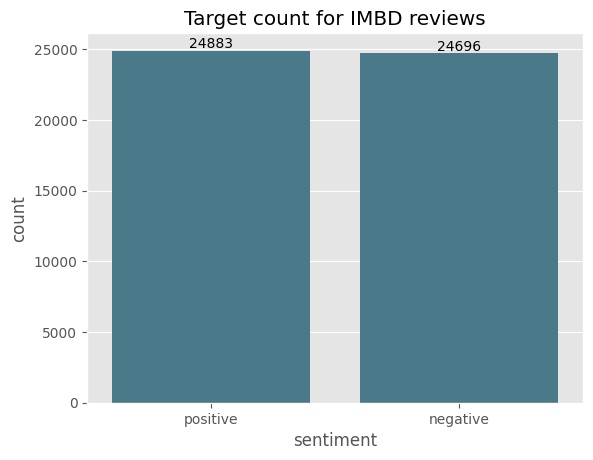

In [18]:
ax = sns.countplot(data=df, x = "sentiment")
plt.title('Target count for IMBD reviews')
ax.bar_label(ax.containers[0], fmt="%d")
plt.show()

**3.2. WordCloud**

A word cloud is a visual representation of the frequency of words in a text. Words that appear more frequently are displayed in larger fonts, while less frequent words are shown in smaller sizes. It is commonly used to quickly identify prominent terms in a dataset, offering a simple way to visualize the importance or repetition of certain words in a document or collection of texts.

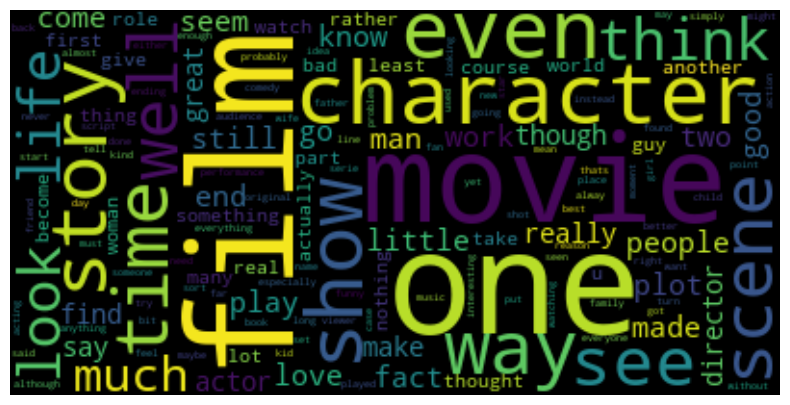

In [20]:
generate_word_cloud(df, "review", max_font_size= 75, max_words = 150 )

**3.2. Distribution of Number of Words Per Reviews**

The words used in negative and positive reviews have been counted and visualized, revealing that people tend to use more words in negative reviews. In both graphs, the rightward skew indicates that certain words are used very frequently in both negative and positive reviews.

In [21]:
positive_reviews = df.loc[df["sentiment"]=="positive", "review"]
negative_reviews = df.loc[df["sentiment"]=="negative", "review"]

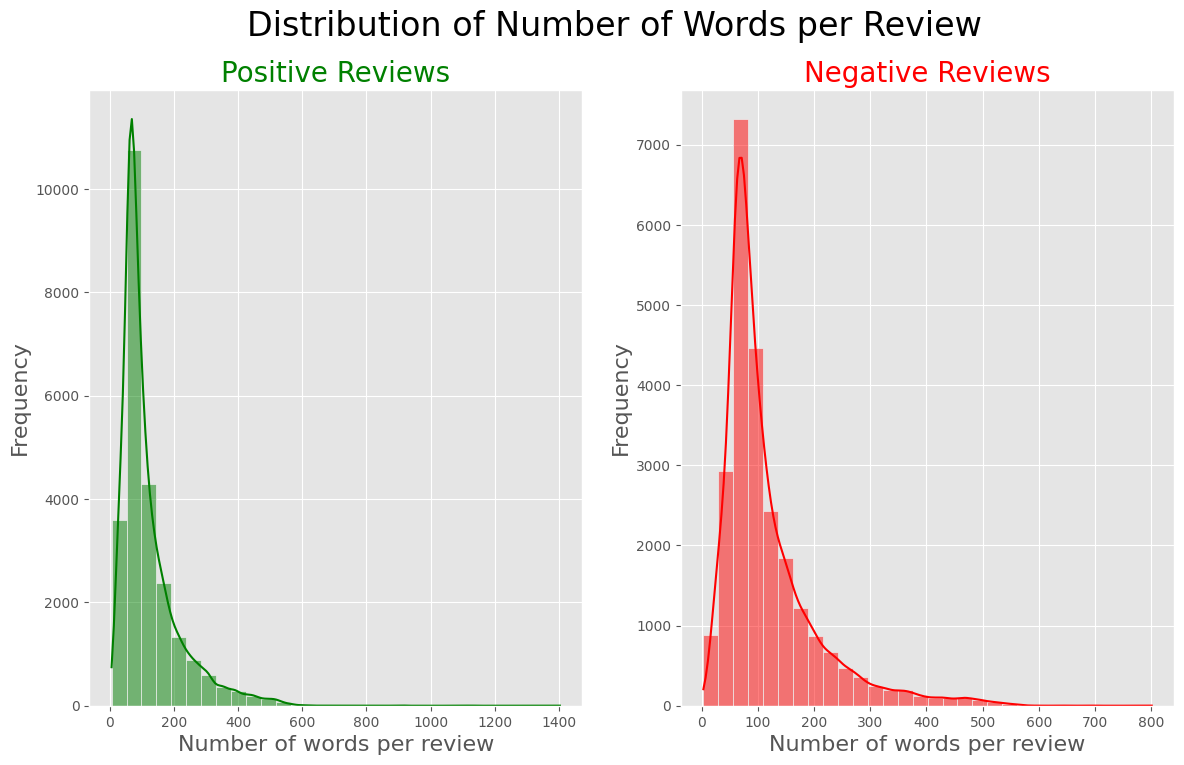

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

positive_word_counts = positive_reviews.str.split().apply(len)
sns.histplot(positive_word_counts, ax=ax1, bins=30, kde=True, color="green")  
ax1.set_title("Positive Reviews", fontsize=20, color="green")  
ax1.set_xlabel("Number of words per review", fontsize=16)  
ax1.set_ylabel("Frequency", fontsize=16) 

negative_word_counts = negative_reviews.str.split().apply(len)
sns.histplot(negative_word_counts, ax=ax2, bins=30, kde=True, color="red")  
ax2.set_title("Negative Reviews", fontsize=20, color="red") 
ax2.set_xlabel("Number of words per review", fontsize=16) 
ax2.set_ylabel("Frequency", fontsize=16) 

fig.suptitle("Distribution of Number of Words per Review", fontsize=24)
plt.show()

**3.3. Most Frequent Words in Negative and Positive Reviews**

The 10 most common words in negative and positive comments are visualized



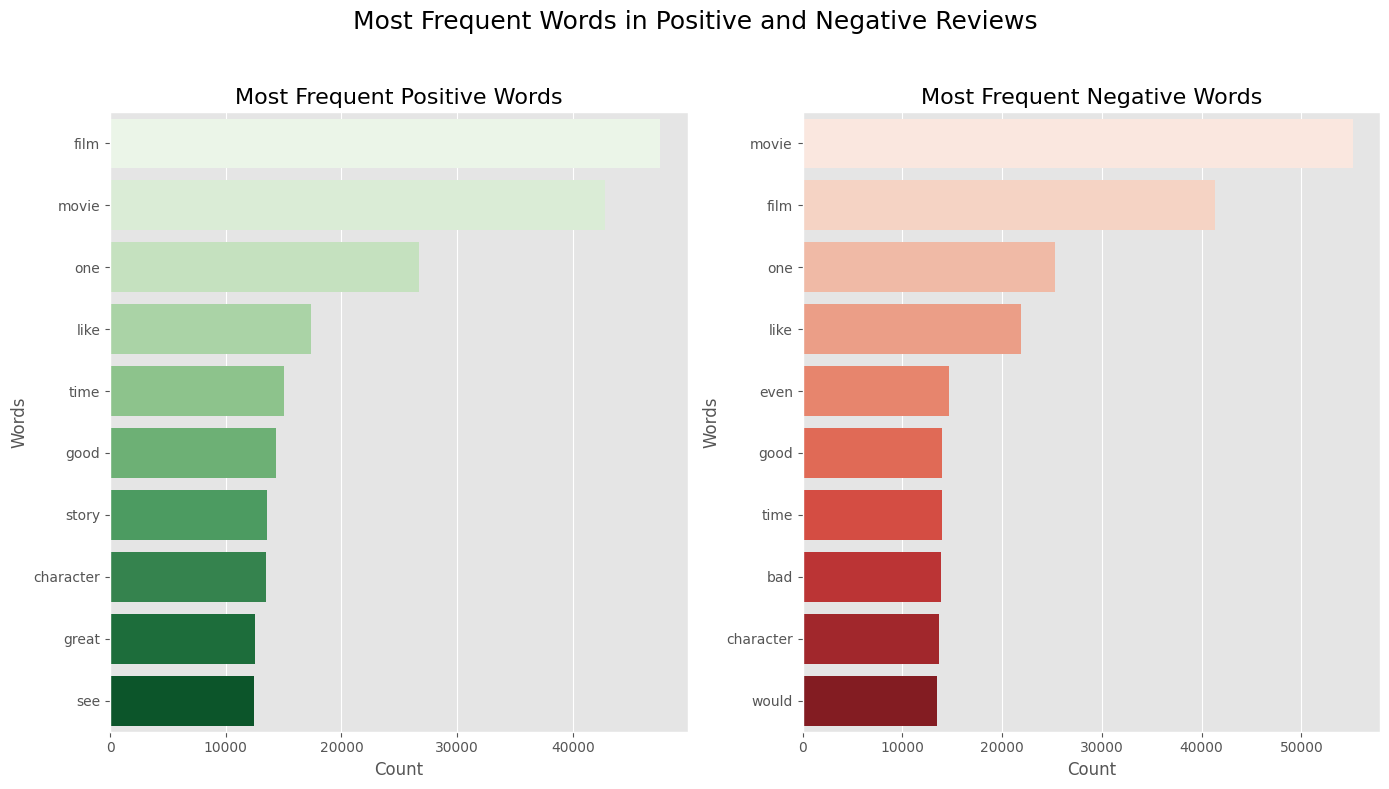

In [23]:
positive_words = positive_reviews.str.split(expand=True).stack().value_counts()
negative_words = negative_reviews.str.split(expand=True).stack().value_counts()

positive_top_words = positive_words.head(10).reset_index()
negative_top_words = negative_words.head(10).reset_index()

positive_top_words.columns = ['word', 'count']
negative_top_words.columns = ['word', 'count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

sns.barplot(x='count', y='word', data=positive_top_words, ax=ax1, palette='Greens')
ax1.set_title('Most Frequent Positive Words', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Words', fontsize=12)

sns.barplot(x='count', y='word', data=negative_top_words, ax=ax2, palette='Reds')
ax2.set_title('Most Frequent Negative Words', fontsize=16)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Words', fontsize=12)

plt.suptitle('Most Frequent Words in Positive and Negative Reviews', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### **4. Vectorization**

Vectorization is a crucial step in natural language processing (NLP) that transforms text data into numerical representations, enabling machine learning models to understand and process the information. Various methods are employed for vectorization, each with its unique characteristics and applications:

1. `Bag of Words (BoW)` 

    The Bag of Words method is a simple approach that represents text data based on the frequency of words. Each document is treated as a collection of words, and the frequency of each word is counted, resulting in vectors that ignore the order of words or grammatical structure.

2. `Term Frequency-Inverse Document Frequency (TF-IDF)`
   
   TF-IDF vectorization was developed to address some of the biases that could arise from Count vectorizer. By weighing the frequency of words against their importance in the document corpus, TF-IDF helps to mitigate the influence of commonly used words that may not carry significant meaning, thus providing a more nuanced representation of text data.


`N-Grams`

N-grams are a concept that is specific to text vectorization methods, including Count Vectorizer and TF-IDF Vectorizer.

Explanation:
 N-grams: An n-gram is a contiguous sequence of n items (words, characters, etc.) from a given text. For example:

- Unigrams: Single words (e.g., "happy", "sad").
- Bigrams: Pairs of consecutive words (e.g., "very happy", "not good").
- Trigrams: Triplets of consecutive words (e.g., "not very happy").
    
Both Count Vectorizer and TF-IDF Vectorizer can use n-grams to capture the relationships and context between words, enhancing the representation of text data for machine learning tasks. This allows the models to take into account phrases or specific word combinations rather than treating each word as an isolated feature.


3. `Word Embeddings`

    Word embeddings are a technique that represents words in a continuous vector space, capturing the semantic relationships between words. This method is typically used with deep learning models and provides richer and more meaningful representations by considering the context of words, using techniques such as Word2Vec or GloVe.




### **5. Sentiment Modelling**

Sentiment analysis has evolved significantly from its inception to the present day. Initially, the field relied on rule-based systems and early machine learning models, such as Naive Bayes, Support Vector Machines (SVMs) and Xgboost. The introduction of deep learning brought advancements with Long Short-Term Memory (LSTM) networks, which improved the ability to process sequential data. The breakthrough came with the transformer architecture, which paved the way for models like BERT (Bidirectional Encoder Representations from Transformers) in 2018, allowing for a deeper understanding of language context. Currently, large language models (LLMs) are at the forefront, utilizing vast datasets and computational power to achieve unprecedented levels of accuracy in sentiment analysis. This study aims to cover these developments comprehensively, showcasing the journey of sentiment analysis over time.

**5.1 Sentiment Analysis with Machine Learning Models Using Three Different Vectorization Techniques**

 Vectorization techniques have also evolved over time. These techniques include Bag of Words, TF-IDF, and currently the most widely used, Word Embeddings. This section aims to train a classification model using Logistic Regression and Naive Bayes, incorporating all of these techniques to observe performance differences.


**5.1.1. Bag of Words (BoW)**

Smple test set

First 3 reviews are positive last 3 reviews are negative

In [157]:
sample_reviews = [
    "This movie was an absolute masterpiece! The storyline was captivating and the acting was phenomenal.",
    "I thoroughly enjoyed the film! The characters were relatable and the plot kept me engaged from start to finish.",
    "An incredible cinematic experience! The visuals were stunning, and the soundtrack perfectly complemented the story.",
    "Unfortunately, this film was quite disappointing. The plot was predictable and lacked depth.",
    "I was really bored throughout the movie. It felt too long, and the pacing was very slow.",
    "This movie had potential, but it failed to deliver. The acting was subpar and the dialogue was cringeworthy."
]
sample_reviews_df = pd.DataFrame(sample_reviews, columns=["review"])

Before we begin, we convert our target variable, sentiment, into a numerical format, with positive sentiments represented as 1 and negative sentiments as 0.

In [24]:
df["sentiment"] = np.where(df["sentiment"] == "positive", 1 , 0)
df["sentiment"].value_counts()

sentiment
1    24883
0    24696
Name: count, dtype: int64

Split data as train and test

In [25]:
feature = "review"
target = "sentiment"
X = df[feature]
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(39663,) (9916,)
(39663,) (9916,)


LogisticRegression model with Bag of Words vectorizing

In [27]:
bow_vectorizer = CountVectorizer(ngram_range=(2, 2)).fit(X_train)
x_train_bow = bow_vectorizer.transform(X_train)
x_test_bow = bow_vectorizer.transform(X_test)

Train cross validation score: 0.85
Final test score: 0.86


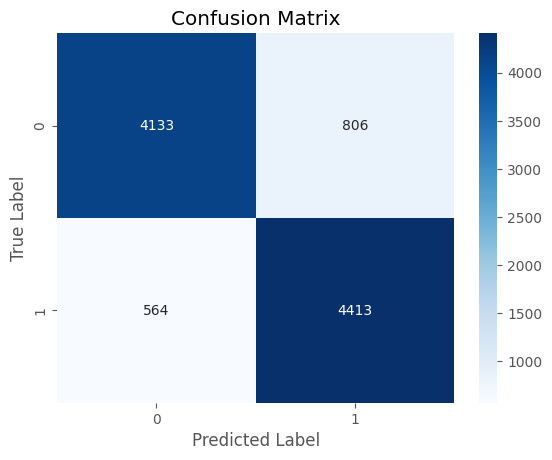

In [118]:
lr_model_bow = LogisticRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_model_trained_bow = train_and_evaluate_model(lr_model_bow, x_train_bow, y_train, x_test_bow, y_test, "accuracy", accuracy_score, skf)

Prediction From Test Set

In [143]:
random_review = pd.Series(X_test.sample(1).values)
predict_sentiment(model=lr_model_trained_bow, vectorizer=bow_vectorizer, review= random_review)

Review:  
one better made tv biopics wish told u read many biography seen thing carpenter movie could based constraint placed family cynthis gibb wonderful job trying toing karen life one disappointment insight karen anorexia reading done disease especially cherry boone oneills wonderful book starving attention anorexia appears disease control karen saw weight one thing life could control felt controlled every aspect life dont get wrong believed truly loved music felt little control career truly loved family express well didnt know make family understand film could touched much treasure music carpenter wish still alive contribute music today 

 Prediction: positive


Prediction From Sample Test Set

In [156]:
df_samples_clean= text_preprocessing(sample_reviews_df, "review")
df_samples_clean_list = pd.Series(df_samples_clean["review"]).tolist()
for review in df_samples_clean_list:
    predict_sentiment(model=lr_model_trained_bow, vectorizer=bow_vectorizer, review= review)
    print(50 * "*")

WordNet is already downloaded.
Review:  
movie absolute masterpiece storyline captivating acting phenomenal 

 Prediction: positive
**************************************************
Review:  
thoroughly enjoyed film character relatable plot kept engaged start finish 

 Prediction: positive
**************************************************
Review:  
incredible cinematic experience visuals stunning soundtrack perfectly complemented story 

 Prediction: positive
**************************************************
Review:  
unfortunately film quite disappointing plot predictable lacked depth 

 Prediction: negative
**************************************************
Review:  
really bored throughout movie felt long pacing slow 

 Prediction: negative
**************************************************
Review:  
movie potential failed deliver acting subpar dialogue cringeworthy 

 Prediction: negative
**************************************************


Review:  
movie absolute masterpiece storyline captivating acting phenomenal 

 Prediction: positive
Review:  
thoroughly enjoyed film character relatable plot kept engaged start finish 

 Prediction: positive
Review:  
incredible cinematic experience visuals stunning soundtrack perfectly complemented story 

 Prediction: positive
Review:  
unfortunately film quite disappointing plot predictable lacked depth 

 Prediction: negative
Review:  
really bored throughout movie felt long pacing slow 

 Prediction: negative
Review:  
movie potential failed deliver acting subpar dialogue cringeworthy 

 Prediction: negative


Naive Bayes model with Bag of Words vectorizing

Train cross validation score: 0.87
Final test score: 0.87


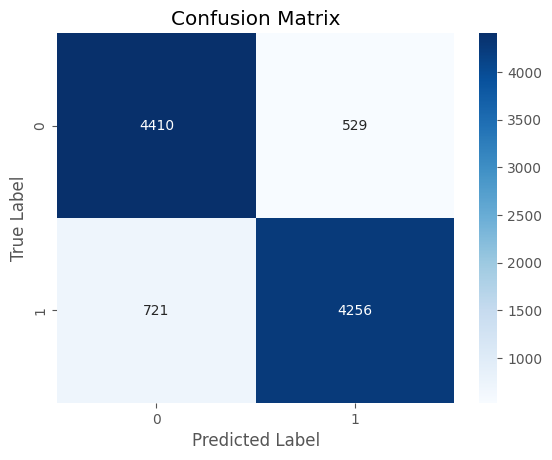

In [48]:
nb_model_bow = MultinomialNB()
train_and_evaluate_model(nb_model_bow, x_train_bow, y_train, x_test_bow, y_test, "accuracy", accuracy_score, skf)